In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kstest, mannwhitneyu, ttest_ind, levene, kruskal
from sklearn.preprocessing import StandardScaler

In [121]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, auc, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [11]:
def spearman_test(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

# Анализ и предобработка данных

In [60]:
df = pd.read_csv('credit_scoring.csv')
df.drop('client_id', axis=1, inplace = True)

In [72]:
df

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90,Income_to_cat
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,False,low
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,False,low
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,False,low
5,0.121965,73.5,18,1,1.0,0,0,15634.752299,0.004951,False,medium
6,0.461193,71.3,9,0,0.0,0,0,3562.767475,0.039618,False,low
...,...,...,...,...,...,...,...,...,...,...,...
74994,0.158635,46.1,7,1,1.0,0,0,12220.413834,0.370935,False,medium
74995,0.169463,67.6,5,1,0.0,0,0,20129.654428,0.074689,False,medium
74997,0.118935,23.0,4,0,0.0,2,0,2019.117329,0.384511,False,low
74998,0.203414,46.3,14,2,0.0,0,0,16823.909642,0.524093,False,medium


In [61]:
df['Delinquent90'] = df['Delinquent90'].astype(bool)

In [62]:
df.shape

(75000, 10)

In [63]:
df.duplicated().sum()

17

In [64]:
df = df.drop_duplicates()

In [65]:
df.describe()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
count,74983.000000,74983.000000,74983.000000,74983.000000,73069.000000,74983.000000,74983.000000,6.015200e+04,74983.000000
mean,353.340383,52.594744,8.451276,1.016924,0.756121,0.428417,0.248056,6.740171e+03,6.277619
std,2117.470748,14.867025,5.156017,1.124042,1.108180,4.276919,4.239965,1.422885e+04,267.773654
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.176160,41.300000,5.000000,0.000000,0.000000,0.000000,0.000000,3.421364e+03,0.029748
50%,0.366924,52.200000,8.000000,1.000000,0.000000,0.000000,0.000000,5.424589e+03,0.153859
75%,0.863070,63.100000,11.000000,2.000000,1.000000,0.000000,0.000000,8.291619e+03,0.560731
max,332600.272820,109.800000,56.000000,32.000000,20.000000,98.000000,98.000000,1.805573e+06,50873.874533


## Обработка пропусков

In [66]:
df.isna().sum()

DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             1914
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14831
BalanceToCreditLimit         0
Delinquent90                 0
dtype: int64

In [68]:
df['Income_to_cat'] = df['Income'].fillna(-1)
bins_income = [-1,0,10000,100000,10000000]
lab_inc =['uknown','low', 'medium', 'high']
df['Income_to_cat'] = pd.cut(df['Income_to_cat'],bins = bins_income, labels = lab_inc, include_lowest=True)
df.dropna(subset = 'Income', inplace = True)

У дохода почти 15тыс пропусков, заменять их будет некорректно, поэтому удалим эти строки из датасета

In [69]:
df.isna().sum()

DIR                      0
Age                      0
NumLoans                 0
NumRealEstateLoans       0
NumDependents            0
Num30-59Delinquencies    0
Num60-89Delinquencies    0
Income                   0
BalanceToCreditLimit     0
Delinquent90             0
Income_to_cat            0
dtype: int64

In [75]:
for col in df.columns:
    n = df[col].nunique()
    print(f'{col}: {n}')

DIR: 56371
Age: 507
NumLoans: 55
NumRealEstateLoans: 24
NumDependents: 13
Num30-59Delinquencies: 16
Num60-89Delinquencies: 11
Income: 59346
BalanceToCreditLimit: 52486
Delinquent90: 2
Income_to_cat: 4


In [83]:
float_features = ['DIR', 'Age', 'BalanceToCreditLimit', 'Income']
int_features = ['NumLoans', 'NumRealEstateLoans', 'NumDependents', 'Num30-59Delinquencies', 'Num60-89Delinquencies']
num_features = float_features + int_features
cat_features = 'Income_to_cat'
target = 'Delinquent90'

In [91]:
df[target].value_counts() # Сильный дисбаланс классов

False    55966
True      4186
Name: Delinquent90, dtype: int64

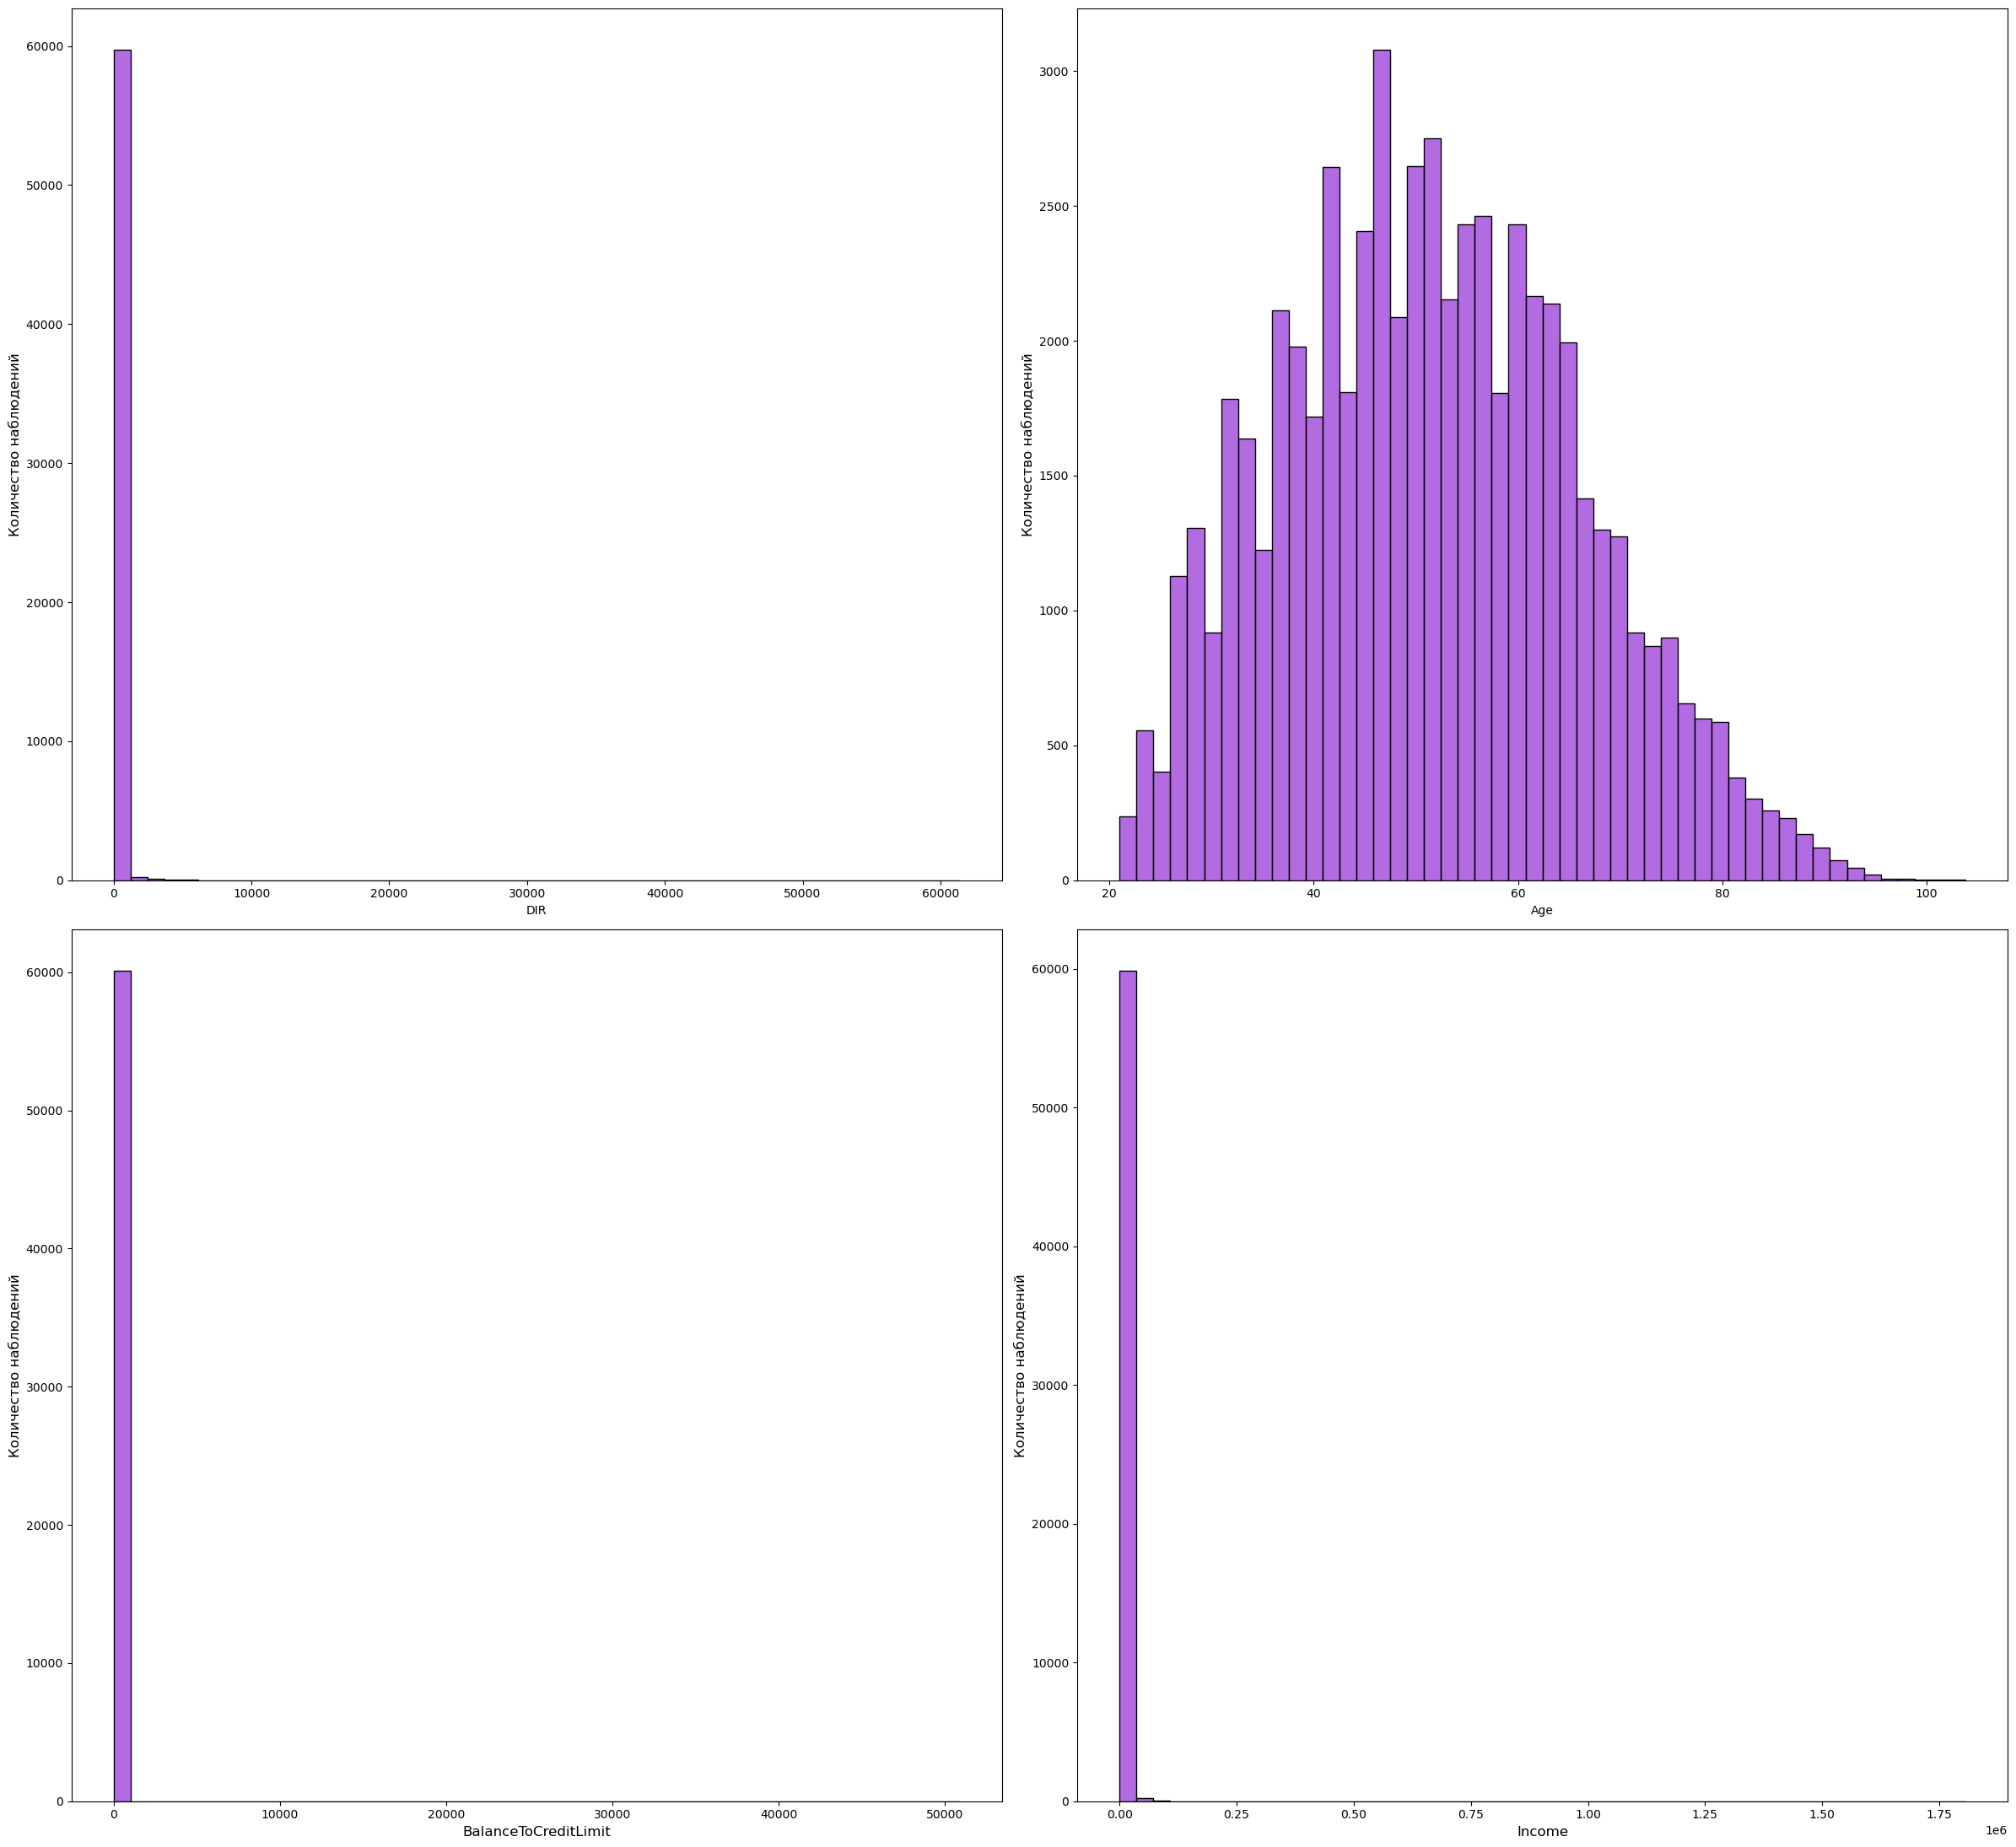

In [87]:
k = 0
m = 2
fig, axes = plt.subplots(m, m, figsize=(24, 22))

for i, ax in enumerate(axes.flat):
    if i >= len(float_features):
        break
    sns.histplot(ax=ax, data=df, x=float_features[i], color='#9939d6', bins = 50)
    ax.set_ylabel('Количество наблюдений', fontsize=12)
    if i >= m * (m - 1):  # Set x-label only for the bottom row
        ax.set_xlabel(float_features[i], fontsize=12)

plt.tight_layout()
plt.show()

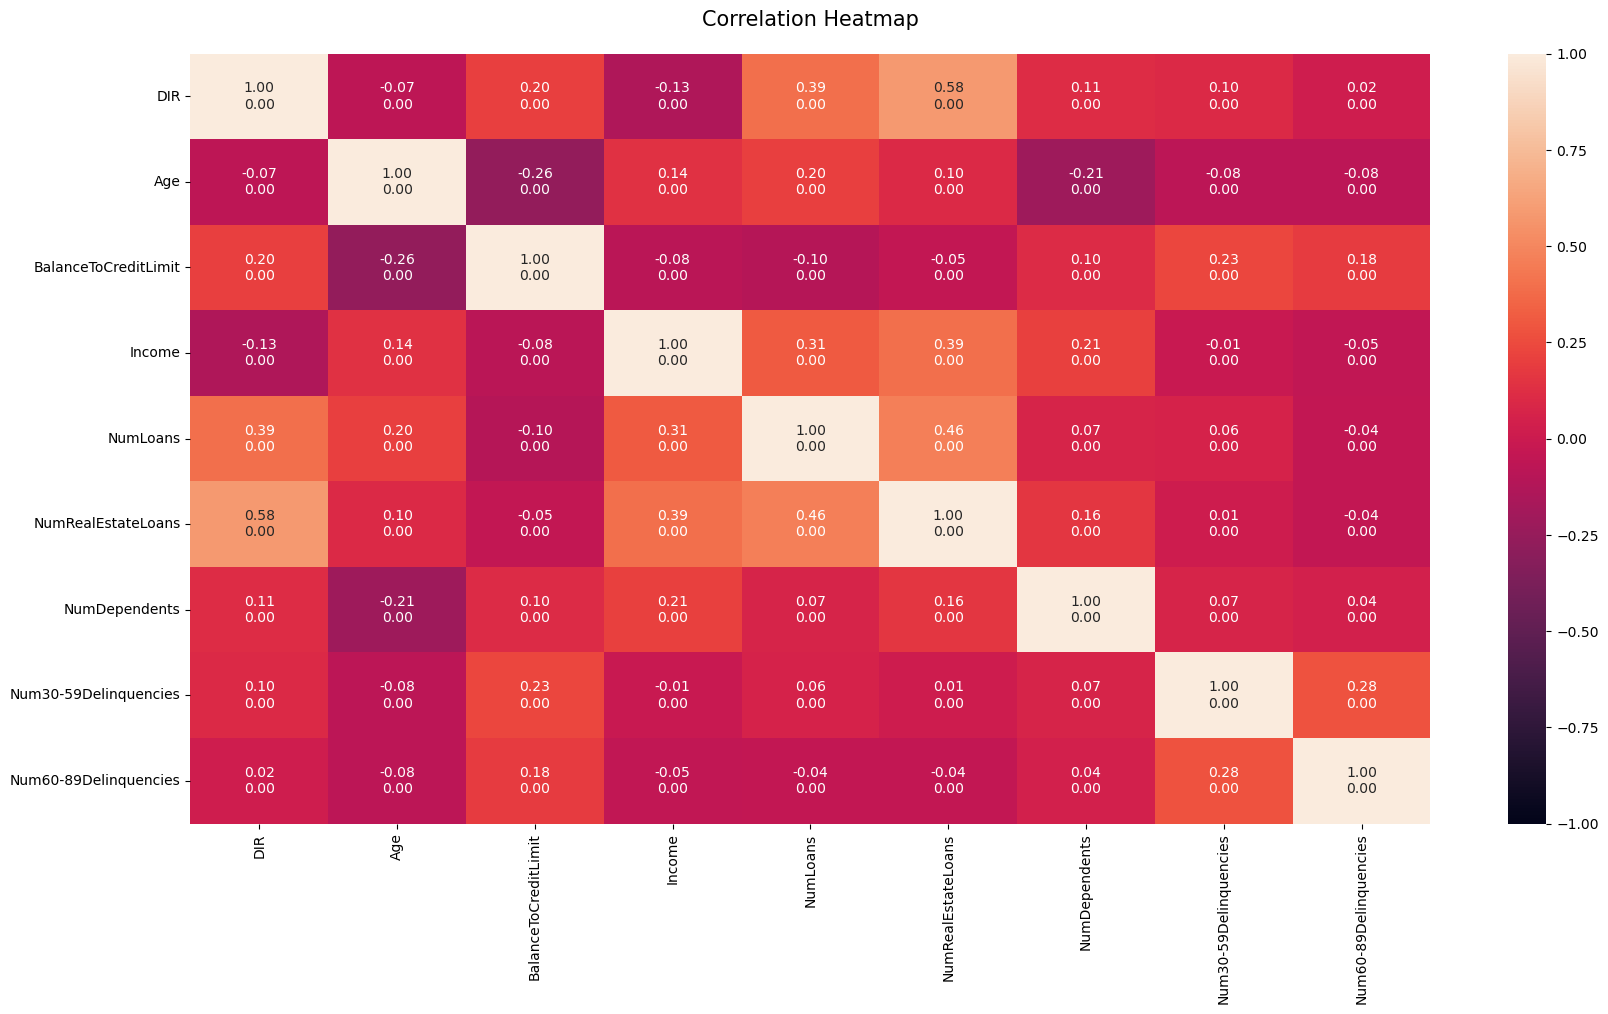

In [84]:
correlation = df[num_features].corr(method = 'spearman')
table = [[spearman_test(df[i], df[j]) for i in num_features] for j in num_features]
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=table, fmt='' )
heatmap.set_title('Correlation Heatmap', fontdict ={'fontsize':15}, pad=20);

Сильной мультиколлинеарности не обнаружено

**Критерий Левина** Н0: Дисперсии равны   
**Критерий Манна-Уитни** Н0: Средние/медианы равны

In [88]:
result = {}
for column in num_features:
    groups = [df[df[target] == i][column].values for i in df[target].unique()]
    result[column] = [mannwhitneyu(*groups), levene(*groups, center='median')]
result

{'DIR': [MannwhitneyuResult(statistic=103285247.5, pvalue=2.064515816947957e-37),
  LeveneResult(statistic=0.044826552761328416, pvalue=0.832324000758171)],
 'Age': [MannwhitneyuResult(statistic=144321431.5, pvalue=7.121739145557109e-139),
  LeveneResult(statistic=164.1865523308047, pvalue=1.5423016653249243e-37)],
 'BalanceToCreditLimit': [MannwhitneyuResult(statistic=55518898.0, pvalue=0.0),
  LeveneResult(statistic=0.0496676915608928, pvalue=0.8236432838842078)],
 'Income': [MannwhitneyuResult(statistic=135221928.0, pvalue=1.584951421074665e-62),
  LeveneResult(statistic=11.086006090953235, pvalue=0.0008703386970099591)],
 'NumLoans': [MannwhitneyuResult(statistic=126442090.0, pvalue=7.563191437169406e-18),
  LeveneResult(statistic=76.68464622692323, pvalue=2.056447021528072e-18)],
 'NumRealEstateLoans': [MannwhitneyuResult(statistic=125350904.5, pvalue=1.3449313001996985e-15),
  LeveneResult(statistic=134.83049514706028, pvalue=3.8820629176401963e-31)],
 'NumDependents': [Mannwhitn

Статистическое равенство дисперсий у признаков:   
- DIR
- BalanceToCreditLimit
Медианы всех признаков имеют статистические различия    
**Вывод:** В модели можно использовать все признаки

## Скалирование

In [92]:
X_train, X_test, y_train, y_test = train_test_split( 
    df[num_features],
    df[target],
    test_size=0.3,
    random_state=42)

In [93]:
X_train

,DIR,Age,BalanceToCreditLimit,Income,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies
24316,0.803816,75.0,1.041474,2623.570497,7,0,0.0,0,0
30899,0.264155,41.3,0.448952,8733.311095,9,2,1.0,0,0
58619,0.458977,32.0,0.193360,3089.702828,8,1,0.0,0,0
19115,0.289217,56.1,0.609524,15078.930872,27,1,0.0,0,0
38112,1891.121347,61.4,0.476795,0.000000,16,1,0.0,0,0
...,...,...,...,...,...,...,...,...,...
67746,0.244282,44.2,0.077430,5349.324170,11,1,0.0,0,0
47531,0.369780,46.3,0.990148,8433.918210,4,1,0.0,0,0
1058,0.294454,57.6,0.083108,4329.439194,9,1,0.0,1,0
19769,0.108980,27.1,1.000754,4505.843111,2,0,1.0,1,0


In [97]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()
X_train = scaler_train.fit_transform(X_train)
X_test = scaler_test.fit_transform(X_test)

# 1. Дерево решений

In [114]:
dtc = DecisionTreeClassifier(
    criterion = "entropy",
    class_weight = 'balanced',
    random_state=42,
    max_depth=3)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [115]:
precision_list =[]
recall_list =[]
f1_list = []
depth_list = range(1,12)
for i in depth_list:
    dtc = DecisionTreeClassifier(
    criterion = "entropy",
    random_state=42,
    max_depth=i)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


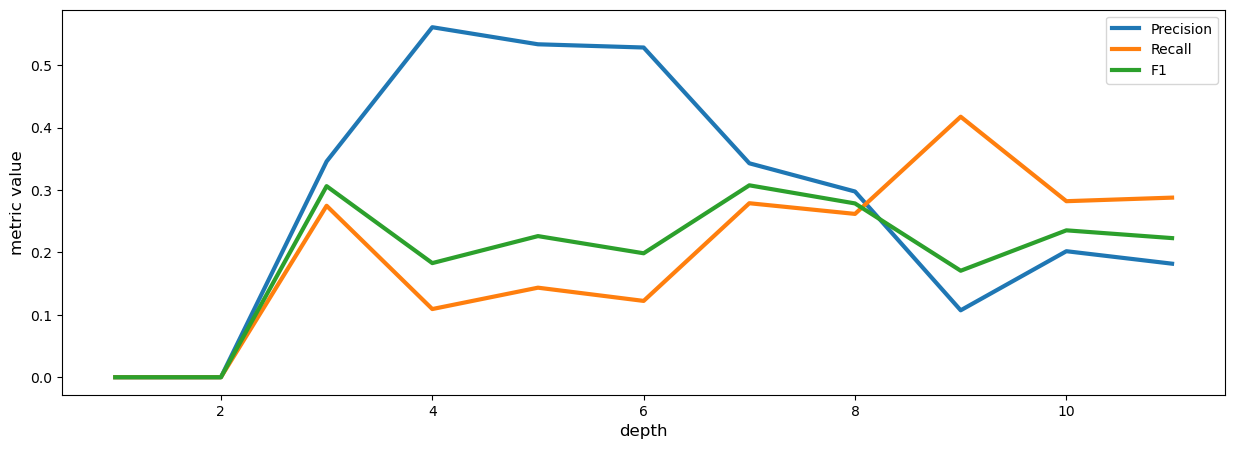

In [116]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(depth_list, precision_list, linewidth = 3,label = 'Precision')
ax.plot(depth_list, recall_list, linewidth = 3,label = 'Recall')
ax.plot(depth_list, f1_list, linewidth = 3,label = 'F1')

plt.legend(loc = "upper right")
plt.xlabel('depth',fontsize = 12)
plt.ylabel('metric value',fontsize = 12)
plt.show()

**Когда начинается преобучение?**

In [123]:
grid = {'max_depth': range(1,12), 'class_weight': [None, 'balanced']}
model_dt = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [124]:
gs = GridSearchCV(model_dt, grid, cv = skf, scoring = 'roc_auc')
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': range(1, 12)},
             scoring='roc_auc')

In [131]:
gs.best_params_

{'class_weight': None, 'max_depth': 6}

In [132]:
dtc = DecisionTreeClassifier(
    random_state=42,
    max_depth=6)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

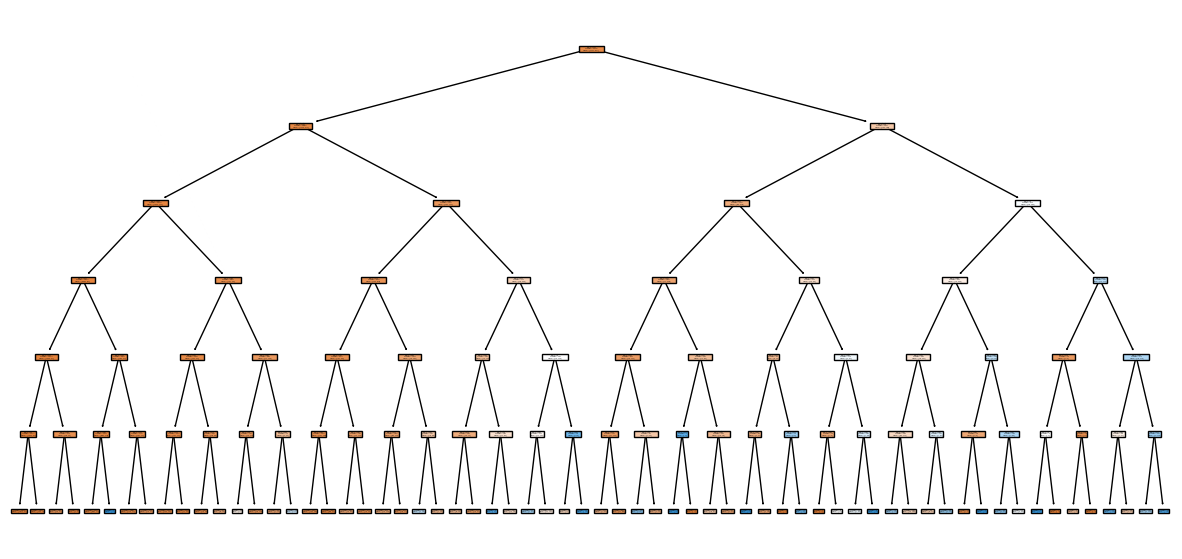

In [133]:
fig = plt.figure(figsize=(15, 7))
tree.plot_tree(dtc, filled=True, feature_names=num_features)
plt.show()